In [1]:
import os
import os.path as op

In [11]:
from mtpy import utils

In [6]:
import numpy as np

## 1D Forward Modeling of MT Data

In [45]:
import math
import cmath
import time

start = time.clock();

mu = 4*math.pi*1E-7; #Magnetic Permeability (H/m)
resistivities = [300, 2500, 0.8, 3000, 2500];
thicknesses = [200, 400, 40, 500];
n = len(resistivities);

frequencies = [.0001,0.0001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,200,300,400,500,600,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000];
print('freq\tares\t\t\tphase');
apparentResistivity=list()

for frequency in frequencies:   
    w =  2*math.pi*frequency;       
    impedances = list(range(n));
    #compute basement impedance
    impedances[n-1] = cmath.sqrt(w*mu*resistivities[n-1]*1j);


   
    for j in range(n-2,-1,-1):
        resistivity = resistivities[j];
        thickness = thicknesses[j];
  
        # 3. Compute apparent resistivity from top layer impedance
        #Step 2. Iterate from bottom layer to top(not the basement) 
        # Step 2.1 Calculate the intrinsic impedance of current layer
        dj = cmath.sqrt((w * mu * (1.0/resistivity))*1j);
        wj = dj * resistivity;
        # Step 2.2 Calculate Exponential factor from intrinsic impedance
        ej = cmath.exp(-2*thickness*dj);                     
    
        # Step 2.3 Calculate reflection coeficient using current layer
        #          intrinsic impedance and the below layer impedance
        belowImpedance = impedances[j + 1];
        rj = (wj - belowImpedance)/(wj + belowImpedance);
        re = rj*ej; 
        Zj = wj * ((1 - re)/(1 + re));
        impedances[j] = Zj;    
    
    # Step 3. Compute apparent resistivity from top layer impedance
    Z = impedances[0];
    absZ = abs(Z);
    apparentResistivity.append((absZ * absZ)/(mu * w));
    phase = math.atan2(Z.imag, Z.real)
    #print(frequency, '\t', apparentResistivity, '\t', phase);
    
print(apparentResistivity);
print('time taken = ', time.clock() - start, 's');



freq	ares			phase
[2261.517499567936, 2261.517499567936, 1274.7285512555263, 997.7172890535873, 435.8126507144753, 273.8525552239266, 78.49519062166195, 45.23031947523922, 24.458612784461803, 34.234784851703914, 143.13776091917669, 270.13876061773254, 450.0516589875723, 530.885340597294, 547.6869192536805, 533.3425959747472, 506.9358741396681, 401.2286842794934, 290.56903305951556, 268.227276704465, 269.04098768179983, 275.8587892781745, 283.1958970971018, 289.3295254481902, 293.9207390508817, 297.1258307265378, 299.2377172466316]
time taken =  0.037413699999888195 s


C:\Users\HP\Anaconda3\envs\mtpy\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
C:\Users\HP\Anaconda3\envs\mtpy\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


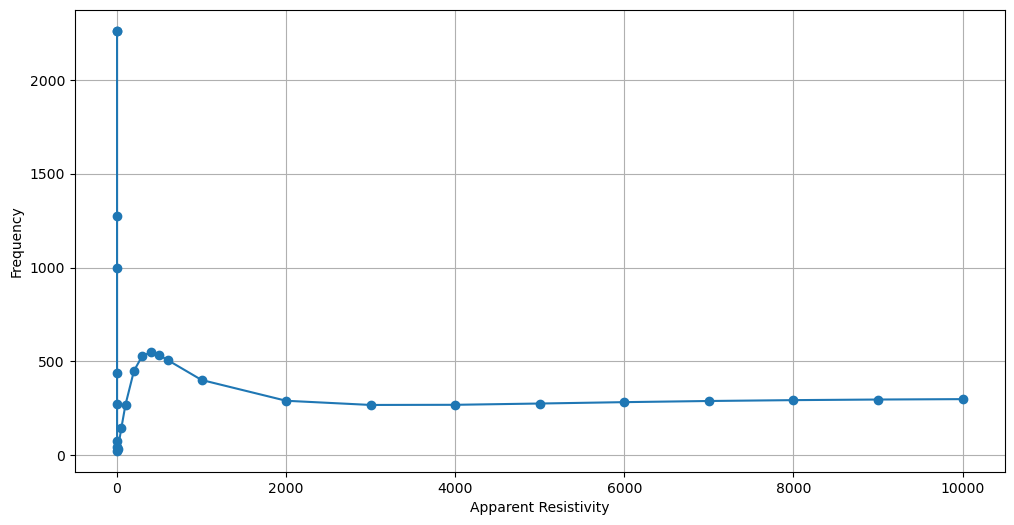

In [48]:
plt.figure(figsize=(12,6))
plt.plot(frequencies,apparentResistivity, marker='o')
plt.xlabel('Apparent Resistivity')
plt.ylabel('Frequency')
plt.grid(True)

## Defining 2D-Forward Modeling Function (MT2DF)

In [13]:
import numpy as np
# from scipy.linalg import lu
import scipy.sparse as scipa 
import scipy.sparse.linalg as scilg
import cmath as cm
class MT2DFD(object):
    #define the forwardmodeling of magnetotelluric
    
    def __init__(self, nza, zn, yn, freq, ry, sig):
        '''
        zn: np.array, size(nz+1,); position of z nodes, begin from 0, Down is the positive direction
        yn: np.array, size(ny+1,); position of y nodes;
        freq: np.array, size(n,);  
        ry: observation system
        sig: conductivity of domain, size(nz,ny);
        nza: number of air layer
        '''
        self.nza = nza
        self.miu = 4.0e-7*np.pi
        self.II = cm.sqrt(-1)
        self.zn = zn
        self.nz = len(zn)
        self.dz = zn[1:] - zn[:-1]
        self.yn = yn
        self.ny = len(yn)
        self.dy = yn[1:] - yn[:-1]
        self.freq = freq 
        self.nf = len(freq)
        self.ry = ry # observation system
        self.nry = len(ry)
        self.sig = sig
        if np.shape(sig) != (self.nz-1,self.ny-1):
            raise ValueError("bad size of sigma, must be (nz-1,ny-1)")
        
    def mt2d(self,mode="TETM"):
        #2-D Magnetotellurics(MT) forward modeling solver.
        dy = self.dy
        dz = self.dz
        sig = self.sig
        yn = self.yn
        ry = self.ry
        nza = self.nza
        
        Ze = np.zeros((self.nf,self.nry),dtype=complex)
        rho = np.zeros((self.nf,self.nry),dtype=float)
        phs = np.zeros((self.nf,self.nry),dtype=float)  
        
        #loop over frequencies.
        if mode == "TE":
            # exrf = np.zeros((self.nf,self.nry),dtype=complex)
            # hyrf = np.zeros((self.nf,self.nry),dtype=complex)        

            for kf in range(0,self.nf):
                ex = self.mt2dte(self.freq[kf],dy,dz,sig)
                hys,hzs = self.mt2dhyhz(self.freq[kf],dy,dz,sig,ex)

                exs = ex[nza,:]
                # interprolation in observation staiton
                exr = np.interp(ry,yn,exs)
                hyr = np.interp(ry,yn,hys)

                zxye,rhote,phste = self.mt2dzxy(self.freq[kf],exr,hyr)
                #exrf[kf] = exr
                #hyrf[kf] = hyr
                Ze[kf]= zxye
                rho[kf] = rhote
                phs[kf] = phste

            zxy = Ze
            #zyx = 0
            return rho,phs,zxy
        elif mode == "TM":
            # exrf = np.zeros((self.nf,self.nry),dtype=complex)
            # hyrf = np.zeros((self.nf,self.nry),dtype=complex)   
            # # no air layer     
            dz = self.dz[nza:]
            sig = self.sig[nza:,:]            
            for kf in range(0,self.nf):
                hx = self.mt2dtm(self.freq[kf],dy,dz,sig)
                eys,ezs = self.mt2deyez(self.freq[kf],dy,dz,sig,hx)

                hxs = hx[0,:]
                hxr = np.interp(ry,yn,hxs)
                eyr = np.interp(ry,yn,eys)

                zxye,rhote,phste = self.mt2dzyx(self.freq[kf],hxr,eyr)
                #exrf[kf] = exr
                #hyrf[kf] = hyr
                Ze[kf]= zxye
                rho[kf] = rhote
                phs[kf] = phste

            zxy = Ze
            #zyx = 0
            return rho,phs,zxy
        elif mode == "TETM":
            Zxy = np.zeros((self.nf,self.nry),dtype=complex)
            Zyx = np.zeros((self.nf,self.nry),dtype=complex)
            rhoxy = np.zeros((self.nf,self.nry),dtype=float)
            phsxy = np.zeros((self.nf,self.nry),dtype=float)  
            rhoyx = np.zeros((self.nf,self.nry),dtype=float)
            phsyx = np.zeros((self.nf,self.nry),dtype=float)  
            # TE
            for kf in range(0,self.nf):
                ex = self.mt2dte(self.freq[kf],dy,dz,sig)
                hys,hzs = self.mt2dhyhz(self.freq[kf],dy,dz,sig,ex)

                exs = ex[nza,:]
                exr = np.interp(ry,yn,exs)
                hyr = np.interp(ry,yn,hys)

                zxye,rhote,phste = self.mt2dzxy(self.freq[kf],exr,hyr)
                #exrf[kf] = exr
                #hyrf[kf] = hyr
                Zxy[kf]= zxye
                rhoxy[kf] = rhote
                phsxy[kf] = phste

            # TM
            # no air layer
            dz = self.dz[nza:]
            sig = self.sig[nza:,:]            
            for kf in range(0,self.nf):
                hx = self.mt2dtm(self.freq[kf],dy,dz,sig)
                eys,ezs = self.mt2deyez(self.freq[kf],dy,dz,sig,hx)

                hxs = hx[0,:]
                hxr = np.interp(ry,yn,hxs)
                eyr = np.interp(ry,yn,eys)

                zxye,rhotm,phstm = self.mt2dzyx(self.freq[kf],hxr,eyr)
                #exrf[kf] = exr
                #hyrf[kf] = hyr
                Zyx[kf]= zxye
                rhoyx[kf] = rhotm
                phsyx[kf] = phstm
            return rhoxy,phsxy,Zxy, rhoyx,phsyx,Zyx

    def mt2dte(self,freq,dy,dz,sig):
        omega = 2.0*np.pi*freq
        ny = self.ny-1
        nz = self.nz-1
        #1.compute the system mat
        # 展平为2维方便矩阵计算
        dy0,dz0 = np.meshgrid(dy,dz)
        dyc = (dy0[0:nz-1,0:ny-1]+dy0[0:nz-1,1:ny])/2.0
        dzc = (dz0[0:nz-1,0:ny-1]+dz0[1:nz,0:ny-1])/2.0
        w1 = dy0[0:nz-1,0:ny-1]*dz0[0:nz-1,0:ny-1] # notice: for index, ny==-1,nz==-1
        w2 = dy0[0:nz-1,1:ny]  *dz0[0:nz-1,0:ny-1]
        w3 = dy0[0:nz-1,0:ny-1]*dz0[1:nz,0:ny-1]
        w4 = dy0[0:nz-1,1:ny]  *dz0[1:nz,0:ny-1]
        area = (w1+w2+w3+w4)/4.0
        sigc = (sig[0:nz-1,0:ny-1]*w1 + sig[0:nz-1,1:ny]*w2 + sig[1:nz,:ny-1]*w3 + sig[1:nz,1:ny]*w4)/(area*4.0)
        val  = dzc/dy0[0:nz-1,0:ny-1] + dzc/dy0[0:nz-1,1:ny] + dyc/dz0[0:nz-1,0:ny-1] +dyc/dz0[1:nz,0:ny-1]
        mtx1 = self.II*omega*self.miu*sigc*area - val
        mtx1 = mtx1.flatten('F') # flatten in column, because outter 'for' loop is in y;
        ##the first lower and upper diagonal terms
        # mtx2 = np.zeros((nz-1,ny-1)-1,dtype=complex)
        mtx20 = dyc[1:nz-1,0:ny-1]/dz0[1:nz-1,0:ny-1]
        mtx2 = np.concatenate((mtx20,np.zeros((1,ny-1))),0)
        mtx2 = mtx2.flatten('F')[:-1] # the last element is not needed.
        ##the secend lower and upper diagonal terms
        mtx3 = dzc[0:nz-1,1:ny-1]/dy0[0:nz-1,1:ny-1]
        mtx3 = mtx3.flatten('F')
        k2 =  nz       
        mtxA = scipa.diags(mtx1,format='csc')+\
            scipa.diags(mtx2,-1,format='csc')+scipa.diags(mtx2,1,format='csc')+\
                scipa.diags(mtx3,1-k2,format='csc')+scipa.diags(mtx3,k2-1,format='csc')
        #2.compute right hand side
        coef = np.zeros((nz+1,ny+1),dtype=float)
        #2.1compute the boundary coeffients
        ##left and right hands
        dzck = (dz0[0:nz-1,0]+dz0[1:nz,0])/2.0
        coef[1:nz,0]  = dzck/dy0[0,0]
        coef[1:nz,ny] = dzck/dy0[0,ny-1]
        ##top and bottom sides
        dycj = (dy0[0,0:ny-1]+dy0[0,1:ny])/2.0
        coef[0,1:ny]  = dycj/dz0[0,0]
        coef[nz,1:ny] = dycj/dz0[nz-1,0]
        #2.2compute the boundary field
        ex1d = np.zeros((nz+1,ny+1),dtype=complex)
        # to do : for matrix
        # for kj in range(0,ny+1):
        #     if kj == 1:
        #         sig1d = sig[:,0]
        #     elif kj == ny:
        #         sig1d = sig[:,ny-1]
        #     else:
        #         # to do : for bottom, given an gauss that field has linear change.
        #         sig1d = (sig[:,kj-1]*dy[kj-1]+sig[:,kj]*dy[kj])/(dy[kj-1]+dy[kj])          
        #     mt1dte = self.mt1dte(freq,dz,sig1d)
        #     # for i in range(0,nz+1):
        #     ex1d[0:nz+1,kj] = mt1dte[0:nz+1,0]

        # supposed that field change linearly in the top and bottom
        ex_l = self.mt1dte(freq,dz,sig[:,0])
        ex_r = self.mt1dte(freq,dz,sig[:,-1])
        ex1d[:,0] = ex_l.flatten() 
        ex1d[:,-1] = ex_r.flatten()
        ex1d[0,:] = np.linspace(ex_l[0,0],ex_r[0,0],ny+1)
        ex1d[-1,:] = np.linspace(ex_l[-1,0],ex_r[-1,0],ny+1)
                
        #2.3forming rhs
        coef = ex1d*coef  
        rhs  = coef[1:nz,1:ny]
        rhs[0,0:ny-1]    = rhs[0,   0:ny-1]+coef[0,1:ny]
        rhs[nz-2,0:ny-1] = rhs[nz-2,0:ny-1]+coef[nz,1:ny]
        rhs[0:nz-1,0]    = rhs[0:nz-1,0]   +coef[1:nz,0]
        rhs[0:nz-1,ny-2] = rhs[0:nz-1,ny-2]+coef[1:nz,ny]
            
        rhs = - rhs
        rhs = rhs.reshape((ny-1)*(nz-1),1,order='F')
        #3.solve the system equation:mtxA * ex = rhs by LU factorization.
        # p,l,u = lu(mtxA)
        # p = np.mat(p)
        # l = np.mat(l)
        # u = np.mat(u)
        # ex = u.I*(l.I*p*rhs)
        # bicgstab solver
        ilu = scilg.spilu(mtxA, drop_tol= 1e-7)
        M = scilg.LinearOperator(ilu.shape, ilu.solve)
        # M = spar.diags(1. / mtx1, offsets = 0, format = 'csc')       
        ex, exitCode = scilg.bicgstab(mtxA, rhs, tol = 1e-09, M = M)
        ex = ex.reshape(nz-1,ny-1,order='F')
        ex1d[1:nz,1:ny] = ex
        ex = ex1d
        return ex
        
    def mt2dtm(self,freq,dy,dz,sig):
        omega = 2.0*np.pi*freq
        ny = len(dy)
        nz = len(dz)
        #1.compute the system mat
        ##the diagnal termsgg
        mtx1 = np.zeros((ny-1)*(nz-1),dtype=complex)
        dy0,dz0 = np.meshgrid(dy,dz)
        dyc = (dy0[0:nz-1,0:ny-1]+dy0[0:nz-1,1:ny])/2.0
        dzc = (dz0[0:nz-1,0:ny-1]+dz0[1:nz,0:ny-1])/2.0
        w1 = 2 * dz0[0:nz-1, 0:ny-1] # dz1
        w2 = 2 * dz0[1:nz,   0:ny-1] # dz2
        w3 = 2 * dy0[0:nz-1, 0:ny-1] # dy1
        w4 = 2 * dy0[0:nz-1, 1:ny]   # dy2
        area = (w1+w2+w3+w4)/4.0
        A = (1.0/sig[0:nz-1,0:ny-1] * dy0[0:nz-1,0:ny-1] + 1.0/sig[0:nz-1,1:ny]*dy0[0:nz-1,1:ny])/w1 # (dy1 * rho_11 + dy2 * rho_12) / (2*dz1)
        B = (1.0/sig[1:nz  ,0:ny-1] * dy0[0:nz-1,0:ny-1] + 1.0/sig[1:nz  ,1:ny]*dy0[0:nz-1,1:ny])/w2 # (dy1 * rho_21 + dy2 * rho_22) / (2*dz2)
        C = (1.0/sig[0:nz-1,0:ny-1] * dz0[0:nz-1,0:ny-1] + 1.0/sig[1:nz,0:ny-1]*dz0[1:nz,0:ny-1])/w3 # (dz1 * rho_11 * dz2 * rho_21) / (2*dy1)
        D = (1.0/sig[0:nz-1,1:ny  ] * dz0[0:nz-1,0:ny-1] + 1.0/sig[1:nz,1:ny  ]*dz0[1:nz,0:ny-1])/w4 # (dz1 * rho_12 + dz2 * rho_22) / (2*dy2)
        mtx1 = self.II * omega * self.miu * dyc * dzc - A - B - C - D
        mtx1 = mtx1.flatten('F') # flatten in column, because outter 'for' loop is in y;        
        ##the first lower and upper diagonal terms 
        mtx20 = B[0:nz-2,0:ny-1]#1.0/sig[1:nz-1,0:ny-1] * dy[1:nz-1,0:ny-1]  + 1.0/sig[1:nz-1, 1:ny]*dy[1:nz-1,1:ny]/(2 * dz[1:nz-1,0:ny-1])
        # mtx2[-1:,:] = 0.0 # the last line is zero
        mtx2 = np.concatenate((mtx20,np.zeros((1,ny-1))),0)
        mtx2 = mtx2.flatten('F')[:-1] # the last element is not needed.
            
        ##the secend lower and upper diagonal terms
        
        mtx3 = D[0:nz-1,0:ny-2]#1.0/sig[0:nz-1,1:ny  ] * dz[0:nz-1,0:ny-1] + 1.0/sig[1:nz,1:ny] * dz[1:nz,0:ny-1]/(2 * dy[0:nz-1,1:ny])
        mtx3 = mtx3.flatten('F')
        k2 =  nz         
        mtxA = scipa.diags(mtx1,format='csc')+\
            scipa.diags(mtx2,-1,format='csc')+scipa.diags(mtx2,1,format='csc')+\
                scipa.diags(mtx3,1-k2,format='csc')+scipa.diags(mtx3,k2-1,format='csc')
        #2.compute right hand side
        coef = np.zeros((nz+1,ny+1),dtype=float)
        #2.1compute the boundary coeffients
        ##left and right hands

        coef[1:nz,0] =  C[:,0]
        coef[1:nz,ny] = D[:,-1]
            
        ##top and bottom sides
        coef[0,1:ny] =  A[0,:]
        coef[nz,1:ny] = B[-1,:]    
        #2.2compute the boundary field
        hx1d = np.zeros((nz+1,ny+1),dtype=complex)
        # for kj in range(0,ny+1):
        #     if kj == 1:
        #         sig1d = sig[:,0]
        #     elif kj == ny:
        #         sig1d = sig[:,ny-1]
        #     else:
        #         sig1d = (sig[:,kj-1]*dy[kj-1]+sig[:,kj]*dy[kj])/(dy[kj-1]+dy[kj])          
        #     mt1dtm = self.mt1dtm(freq,dz,sig1d)
        #     # for i in range(0,nz+1):
        #     hx1d[0:nz+1,kj] = mt1dtm[0:nz+1,0]
        # supposed that field change linearly in the top and bottom
        hx_l = self.mt1dte(freq,dz,sig[:,0])
        hx_r = self.mt1dte(freq,dz,sig[:,-1])
        hx1d[:,0] = hx_l.flatten() 
        hx1d[:,-1] = hx_r.flatten()
        hx1d[0,:] = np.linspace(hx_l[0,0],hx_r[0,0],ny+1)
        hx1d[-1,:] = np.linspace(hx_l[-1,0],hx_r[-1,0],ny+1)
                
        #2.3forming rhs
        coef = hx1d*coef  
        rhs = coef[1:nz,1:ny]
        rhs[0,0:ny-1]    = rhs[0,0:ny-1]    + coef[0,1:ny]
        rhs[nz-2,0:ny-1] = rhs[nz-2,0:ny-1] + coef[nz,1:ny]
            
        rhs[0:nz-1,0]    = rhs[0:nz-1,0]    + coef[1:nz,0]
        rhs[0:nz-1,ny-2] = rhs[0:nz-1,ny-2] + coef[1:nz,ny]
            
        rhs = - rhs
        rhs = rhs.reshape((ny-1)*(nz-1),1,order='F')
        #3.solve the system equation:mtxA * ex = rhs by LU factorization.
        # p,l,u = lu(mtxA)
        # p = np.mat(p)
        # l = np.mat(l)
        # u = np.mat(u)
        # hx = u.I*(l.I*p*rhs)

        # bicgstab solver
        ilu = scilg.spilu(mtxA, drop_tol= 1e-7)
        M = scilg.LinearOperator(ilu.shape, ilu.solve)
        # M = spar.diags(1. / mtx1, offsets = 0, format = 'csc')
        
        hx, exitCode = scilg.bicgstab(mtxA, rhs, tol = 1e-09, M = M)
        hx = hx.reshape(nz-1,ny-1,order='F')
        hx1d[1:nz,1:ny] = hx
        hx = hx1d
        return hx

    def mt2dhyhz(self,freq,dy,dz,sig,ex):
        #Interpolater of H-field for 2-D Magnetotellurics(MT) TE mode solver.
        omega = 2.0*np.pi*freq
        ny = np.size(dy)
        #1.compute Hy
        hys = np.zeros((ny+1),dtype=complex)    
        #1.1compute Hy at the top left corner
        kk = self.nza 
        delz = dz[kk]
        sigc = sig[kk,0]
        c0 = -1.0/(self.II*omega*self.miu*delz) + (3.0/8.0)*sigc*delz
        c1 = 1.0/(self.II*omega*self.miu*delz) + (1.0/8.0)*sigc*delz
        hys[0] = c0*ex[kk,0] + c1*ex[kk+1,0]
        #1.2compute Hy at the top right corner
        sigc = sig[kk,ny-1]
        c0 = -1.0/(self.II*omega*self.miu*delz) + (3.0/8.0)*sigc*delz
        c1 = 1.0/(self.II*omega*self.miu*delz) + (1.0/8.0)*sigc*delz
        hys[ny] = c0*ex[kk,ny] + c1*ex[kk+1,ny]
        #1.3compute the Hy at other nodes
        dyj = dy[0:ny-1]+dy[1:ny]
        sigc = (sig[kk,0:ny-1]*dy[0:ny-1]+sig[kk,1:ny]*dy[1:ny])/dyj
        cc = delz/(4.0*self.II*omega*self.miu*dyj) # should devided by 8.0?
        c0 = -1.0/(self.II*omega*self.miu*delz) + (3.0/8.0)*sigc*delz - cc*3.0*(1.0/dy[1:ny]+1.0/dy[0:ny-1])
        c1 = 1.0/(self.II*omega*self.miu*delz) + (1.0/8.0)*sigc*delz - cc*1.0*(1.0/dy[1:ny]+1.0/dy[0:ny-1])
        c0l = 3.0*cc/dy[0:ny-1]
        c0r = 3.0*cc/dy[1:ny]
        c1l = 1.0*cc/dy[0:ny-1]
        c1r = 1.0*cc/dy[1:ny]
        hys[1:ny] = c0l*ex[kk,0:ny-1] + c0*ex[kk,1:ny] + c0r*ex[kk,2:ny+1] + \
                    c1l*ex[kk+1,0:ny-1] + c1*ex[kk+1,1:ny] + c1r*ex[kk+1,2:ny+1]
        #2.compute Hz
        hzs = np.zeros((ny+1),dtype=complex)
        #2.1compute Hz at the topleft and top right corner
        hzs[0] = -1.0/(self.II*omega*self.miu)*(ex[kk,1]-ex[kk,0])/dy[0]
        hzs[ny] = -1.0/(self.II*omega*self.miu)*(ex[kk,ny]-ex[kk,ny-1])/dy[ny-1]
        #2.2compute Hz at other nodes
        # for kj in range(1,ny):
        hzs[1:ny] = -1.0/(self.II*omega*self.miu)*(ex[kk,2:ny+1]-ex[kk,0:ny-1])/(dy[0:ny-1]+dy[1:ny])

        return hys,hzs
    
    def mt2deyez(self,freq,dy,dz,sig,hx):
        #Interpolater of H-field for 2-D Magnetotellurics(MT) TE mode solver.
        omega = 2.0*np.pi*freq
        ny = np.size(dy)
        #1.compute Hy
        eys = np.zeros((ny+1),dtype=complex)    
        #1.1compute Hy at the top left corner
        # kk = self.nza 
        kk = 0 # no air layer
        delz = dz[kk]
        sigc = sig[kk,0]
        temp_beta = self.II * omega * self.miu * delz
        temp_1 = sigc * delz
        c0 = -1.0/temp_1 + (3.0/8.0)*temp_beta
        c1 = 1.0/temp_1 + (1.0/8.0)*temp_beta
        eys[0] = c0*hx[kk,0] + c1*hx[kk+1,0]
        #1.2compute Hy at the top right corner
        sigc = sig[kk,ny-1]
        temp_1 = sigc * delz
        c0 = -1.0/temp_1 + (3.0/8.0)*temp_beta
        c1 = 1.0/temp_1+ (1.0/8.0)*temp_beta
        eys[ny] = c0*hx[kk,ny] + c1*hx[kk+1,ny]
        #1.3compute the Hy at other nodes
        # for kj in range(1,ny):
        dyj = (dy[0:ny-1]+dy[1:ny])/2.0
        tao = 1.0/sig[kk,0:ny]
        taoc = (tao[0:ny-1]*dy[0:ny-1] + tao[1:ny]*dy[1:ny])/(2*dyj)
        temp_1 = self.II*omega*self.miu*delz
        temp_2 = taoc/delz
        temp_3 = delz/dyj
        temp_4 = tao/dy
        c0 =  (3.0/8.0)*temp_1 - temp_2
        c1 =  (1.0/8.0)*temp_1 + temp_2 - (1.0/8.0)*temp_3*(temp_4[0:ny-1]+temp_4[1:ny])
        c1l = (1.0/8.0)*temp_3*temp_4[0:ny-1]
        c1r = (1.0/8.0)*temp_3*temp_4[1:ny]
        eys[1:ny] = c0*hx[kk,1:ny] + c1l*hx[kk+1,0:ny-1]+c1*hx[kk+1,1:ny]+c1r*hx[kk+1,2:ny+1]
        #2.compute Hz
        ezs = np.zeros((ny+1),dtype=complex)
        # to do

        # #2.1compute Hz at the topleft and top right corner
        # ezs[0] = -1.0/(self.II*omega*self.miu)*(hx[kk,1]-hx[kk,0])/dy[0]
        # ezs[ny] = -1.0/(self.II*omega*self.miu)*(hx[kk,ny]-hx[kk,ny-1])/dy[ny-1]
        # #2.2compute Hz at other nodes
        # for kj in range(1,ny):
        #     ezs[kj] = -1.0/(self.II*omega*self.miu)*(hx[kk,kj+1]-hx[kk,kj-1])/(dy[kj-1]+dy[kj])

        return eys,ezs
        
    def mt2dzxy(self,freq,exr,hyr):
        #compute the impedance, apparent resistivity and phase of TE mode 2-D Magnetotellurics(MT) forward modeling problem
        omega = 2.0*np.pi*freq
        #compute the outputs
        zxy = np.array(exr/hyr,dtype=complex)
        rhote = abs(zxy)**2/(omega*self.miu)
        # nzxy = np.size(zxy.imag)
        # phste = np.zeros(nzxy,dtype=float)
        # for i in range(0,nzxy):
        phste = np.arctan2(zxy.imag, zxy.real)*180.0/np.pi

        return zxy,rhote,phste

    def mt2dzyx(self,freq,hxr,eyr):
        #compute the impedance, apparent resistivity and phase of TE mode 2-D Magnetotellurics(MT) forward modeling problem
        omega = 2.0*np.pi*freq
        #compute the outputs
        zyx = np.array(eyr/hxr,dtype=complex)
        rhotm = abs(zyx)**2/(omega*self.miu)
        # nzyx = np.size(zyx.imag)
        # phstm = np.zeros(nzyx,dtype=float)
        # for i in] range(0,nzyx):
        phstm = np.arctan2(zyx.imag, zyx.real)*180.0/np.pi
            # phstm[i] = cm.phase(zyx[i])*180.0/np.pi

        return zyx,rhotm,phstm
    
    def mt1dte(self,freq,dz,sig):
        #extend model
        omega = 2.0*np.pi*freq
        nz = np.size(sig)

        sig = np.hstack((sig,sig[nz-1]))
        dz = np.hstack((dz,np.array(np.sqrt(2.0/(sig[nz]*omega*self.miu)),dtype=float)))
        
        #compute coefficients
        ##diag elements
        # diagA = [0]*nz
        # for ki in range(0,nz):
        diagA = self.II*omega*self.miu*(sig[0:nz]*dz[0:nz]+sig[1:nz+1]*dz[1:nz+1]) - 2.0/dz[0:nz] - 2.0/dz[1:nz+1]
       
        ##off-diag elements
        # offdiagA = [0]*(nz-1)
        # for ki in range(0,nz-1):
        offdiagA=2.0/dz[1:nz]
        
        ##system matix
        mtxA = scipa.diags(diagA,format='csc')+scipa.diags(offdiagA,1,format='csc')+scipa.diags(offdiagA,-1,format='csc')
        #compute right hand sides
        ##using boundary conditions:ex[0]=1.0,ex[nz-1]=0.0
        rhs = np.zeros((nz,1),dtype=float)
        rhs[0] = -2.0/dz[0]
        # p,l,u = lu(mtxA)
        # p = np.mat(p)
        # l = np.mat(l)
        # u = np.mat(u)
        # ex = u.I*(l.I*p*rhs)
        # bicgstab solver
        ilu = scilg.spilu(mtxA, drop_tol= 1e-7)
        M = scilg.LinearOperator(ilu.shape, ilu.solve)
        # M = spar.diags(1. / mtx1, offsets = 0, format = 'csc')
        
        ex, exitCode = scilg.bicgstab(mtxA, rhs, tol = 1e-09, M = M)
        ex = np.array(np.vstack(([1.0],ex.reshape(-1,1))),dtype=complex)
        return ex

    def mt1dtm(self,freq,dz,sig):
        #extend model
        omega = 2.0*np.pi*freq
        nz = len(sig)

        sig = np.hstack((sig,sig[nz-1]))
        dz = np.hstack((dz,np.array(np.sqrt(2.0/(sig[nz]*omega*self.miu)),dtype=float)))
        
        #compute coefficients
        ##diag elements
        # diagA = np.zeros(nz,dtype=complex)
        # for ki in range(0,nz):
        diagA = self.II*omega*self.miu*(dz[0:nz]+dz[1:nz+1]) - 2.0/(dz[0:nz]*sig[0:nz]) - 2.0/(dz[1:nz+1]*sig[1:nz+1])
       
        ##off-diag elements
        # offdiagA = np.zeros(nz-1,dtype=complex)
        # for ki in range(0,nz-1):
        offdiagA=2.0/(dz[1:nz]*sig[1:nz])
        
        ##system matix
        mtxA = scipa.diags(diagA,format='csc')+scipa.diags(offdiagA,-1,format='csc')+scipa.diags(offdiagA,1,format='csc')
        #compute right hand sides
        ##using boundary conditions:ex[0]=1.0,ex[nz-1]=0.0
        # BCs
        rhs = np.zeros((nz,1))
        rhs[0] = -2.0/(dz[0]*sig[0])
    
        # P,L,U = lu(mtxA)
        # hy  =  np.linalg.solve(U,np.linalg.solve(P.dot(L), rhs))
        # bicgstab solver
        ilu = scilg.spilu(mtxA, drop_tol= 1e-7)
        M = scilg.LinearOperator(ilu.shape, ilu.solve)
        # M = spar.diags(1. / mtx1, offsets = 0, format = 'csc')
        
        hy, exitCode = scilg.bicgstab(mtxA, rhs, tol = 1e-09, M = M)
        hy0 = np.vstack((np.complex(1,0),hy.reshape(-1,1)))
        return hy0    
    

def generate_model(nza, y, z, size_b, size_k, n_freq, alpha = 3.0, mode='random', set_1=100.0, set_2=100.0):
    '''
    nza   : number of air layer
    y     : [-y,y]
    z     : [0,z]: 
    size_b: number of nodes from boundary to kernel domain
    size_k: kernel domain,
    n_freq: number of frequency
    alpha : smoothness of gaussian random field,the larger the more smooth;
    mode  : if random, 下面是mean和std，if bounda, 是lower和upper
    '''
    z_air = np.linspace(-z,0,nza+1)
    zn0 = np.linspace(0, z, size_k+1)
    z_b = np.linspace(zn0[-1],2*zn0[-1],size_b+1)
    zn  = np.concatenate((z_air[:-1],zn0,z_b[1:]))
    # zn  = zn.reshape((len(zn),1))

    yn0 = np.linspace(-y,y,size_k+1)
    y_l = np.linspace(2*yn0[0],yn0[0],size_b+1)
    y_r = np.linspace(yn0[-1],2*yn0[-1],size_b+1)
    yn  = np.concatenate((y_l[:-1],yn0,y_r[1:]))
    # yn  = yn.reshape((len(yn),1)) - np.min(yn)
#     y0 = yn-y_l[0]
    
    freq = np.logspace(1,-3,n_freq)
    # freq = freq.reshape((len(freq),1))
    ry = np.linspace(-y,y,size_k+1)
    # ry = ry.reshape((len(ry),1))-np.min(ry)

    model = np.ones((size_b+size_k+nza,2*size_b+size_k))*1e-2
    model[:nza,:] = 1e-9
#     model0 = gr.gaussian_random_field(alpha = alpha, size = size_k, 
#                                    mode=mode, set_1=set_1, set_2=set_2)
#     model[int(size_b/2)+1:int(size_b/2)+size_k+1, :size_k] = model0
    return zn, yn, freq, ry, model


if __name__ == '__main__':
    alpha = 3.0 # smoothness of gaussian random field,the larger the more smooth;
    nza = 10 # number of air layer
    y = 10e3    # lenght in left and right 
    z = 20e3    # depth
    size_b = 10 # nodes of expand domain
    size_k = 20 # nodes of kernel domain
    n_freq = 2  # number of frequency
    filename = 'MT_random.mat' # filename saved for apparent resistancy and phase. 
    alpha = 3.0
    mode = 'random' # if random, 下面是mean和std，if bounda, 是lower和upper
    set_1 = 100.0
    set_2 = 100.0

    zn, yn, freq, ry, sig = generate_model(nza, y, z, size_b, size_k, n_freq, alpha, mode, set_1, set_2)
    model = MT2DFD(nza, zn, yn, freq, ry, sig)

    rhoxy, phsxy,Zxy,rhoyx,phsyx,Zyx  = model.mt2d("TETM")
    # rhoxy, phsxy,Zxy, rhoyx, phsyx,Zyx  = model.mt2d("TETM")
    # save_model(filename,resis, rhoxy, phsxy, rhoyx, phsyx)
    print(freq)



[1.e+01 1.e-03]


In [14]:
def generate_model(nza, y, z, size_b, size_k, n_freq, alpha = 3.0, mode='random', set_1=100.0, set_2=100.0):
    '''
    nza   : number of air layer
    y     : [-y,y]
    z     : [0,z]: 
    size_b: number of nodes from boundary to kernel domain
    size_k: kernel domain,
    n_freq: number of frequency
    alpha : smoothness of gaussian random field,the larger the more smooth;
    mode  : if random, 下面是mean和std，if bounda, 是lower和upper
    '''
    z_air = np.linspace(-z,0,nza+1)
    zn0 = np.linspace(0, z, size_k+1)
    z_b = np.linspace(zn0[-1],2*zn0[-1],size_b+1)
    zn  = np.concatenate((z_air[:-1],zn0,z_b[1:]))
    # zn  = zn.reshape((len(zn),1))

    yn0 = np.linspace(-y,y,size_k+1)
    y_l = np.linspace(2*yn0[0],yn0[0],size_b+1)
    y_r = np.linspace(yn0[-1],2*yn0[-1],size_b+1)
    yn  = np.concatenate((y_l[:-1],yn0,y_r[1:]))
    # yn  = yn.reshape((len(yn),1)) - np.min(yn)
#     y0 = yn-y_l[0]
    
    freq = np.logspace(1,-3,n_freq)
    # freq = freq.reshape((len(freq),1))
    ry = np.linspace(-y,y,size_k+1)
    # ry = ry.reshape((len(ry),1))-np.min(ry)

    sig = np.ones((size_b+size_k+nza,2*size_b+size_k))*1e-2
    sig[:nza,:] = 1e-9
#     model0 = gr.gaussian_random_field(alpha = alpha, size = size_k, 
#                                    mode=mode, set_1=set_1, set_2=set_2)
#     model[int(size_b/2)+1:int(size_b/2)+size_k+1, :size_k] = model0
    return zn, yn, freq, ry, sig

In [15]:
alpha = 3.0 # smoothness of gaussian random field,the larger the more smooth;
nza = 10 # number of air layer
y = 10e3    # lenght in left and right 
z = 20e3    # depth
size_b = 10 # nodes of expand domain
size_k = 20 # nodes of kernel domain
n_freq = 5  # number of frequency
filename = 'MT_random.mat' # filename saved for apparent resistancy and phase. 
alpha = 3.0
mode = 'random' # if random, 下面是mean和std，if bounda, 是lower和upper
set_1 = 100.0
set_2 = 100.0

In [16]:


zn, yn, freq, ry, sig = generate_model(nza, y, z, size_b, size_k, n_freq, alpha, mode, set_1, set_2)
model = MT2DFD(nza, zn, yn, freq, ry, sig)

rhoxy, phsxy,Zxy,rhoyx,phsyx,Zyx  = model.mt2d("TETM")



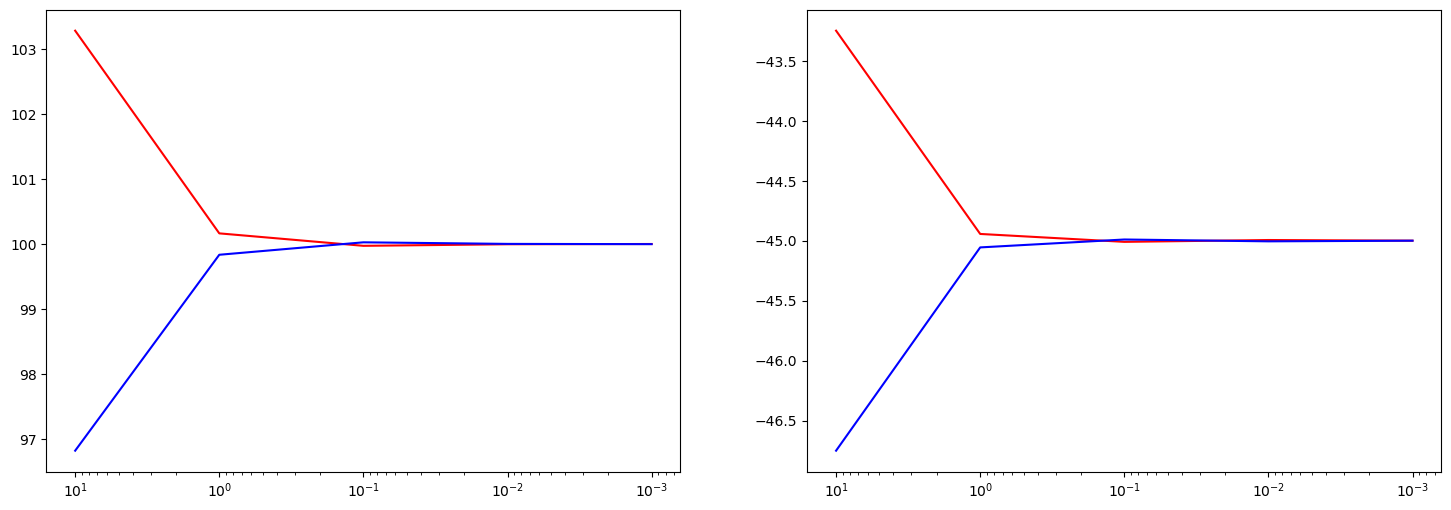

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax.plot(freq, rhoxy[:,0], 'r')
ax.plot(freq, rhoyx[:,0], 'b')
ax.set_xscale("log")
ax.invert_xaxis()

ax = plt.subplot(1,2,2)
ax.plot(freq, phsxy[:,0], 'r')
ax.plot(freq, phsyx[:,0]-180, 'b')
ax.set_xscale("log")
ax.invert_xaxis()
plt.show()



In [23]:
def generate_model(nza, y, z, size_b, size_k, n_freq, alpha = 3.0, mode='random', set_1=100.0, set_2=100.0):
    '''
    nza   : number of air layer
    y     : [-y,y]
    z     : [0,z]: 
    size_b: number of nodes from boundary to kernel domain
    size_k: kernel domain,
    n_freq: number of frequency
    alpha : smoothness of gaussian random field,the larger the more smooth;
    mode  : if random, 下面是mean和std，if bounda, 是lower和upper
    '''
    z_air = np.linspace(-z,0,nza+1)
    zn0 = np.linspace(0, z, size_k+1)
    z_b = np.linspace(zn0[-1],2*zn0[-1],size_b+1)
    zn  = np.concatenate((z_air[:-1],zn0,z_b[1:]))
    # zn  = zn.reshape((len(zn),1))

    yn0 = np.linspace(-y,y,size_k+1)
    y_l = np.linspace(2*yn0[0],yn0[0],size_b+1)
    y_r = np.linspace(yn0[-1],2*yn0[-1],size_b+1)
    yn  = np.concatenate((y_l[:-1],yn0,y_r[1:]))
    # yn  = yn.reshape((len(yn),1)) - np.min(yn)
#     y0 = yn-y_l[0]
    
    freq = np.logspace(1,-3,n_freq)
    # freq = freq.reshape((len(freq),1))
    ry = np.linspace(-y,y,size_k+1)
    # ry = ry.reshape((len(ry),1))-np.min(ry)

    sig = np.ones((size_b+size_k+nza,2*size_b+size_k))*1e-2
    sig[:nza,:] = 1e-9
    sig[nza+5:nza+10,:] = 0.1
#     model0 = gr.gaussian_random_field(alpha = alpha, size = size_k, 
#                                    mode=mode, set_1=set_1, set_2=set_2)
#     model[int(size_b/2)+1:int(size_b/2)+size_k+1, :size_k] = model0
    return zn, yn, freq, ry, sig

In [24]:
zn, yn, freq, ry, sig = generate_model(nza, y, z, size_b, size_k, n_freq, alpha, mode, set_1, set_2)
model = MT2DFD(nza, zn, yn, freq, ry, sig)

rhoxy, phsxy,Zxy,rhoyx,phsyx,Zyx  = model.mt2d("TETM")

In [25]:
rhoxy[:,0]

array([102.87253416, 110.43636727,  37.03769631,  28.58623345,
        58.75470347])

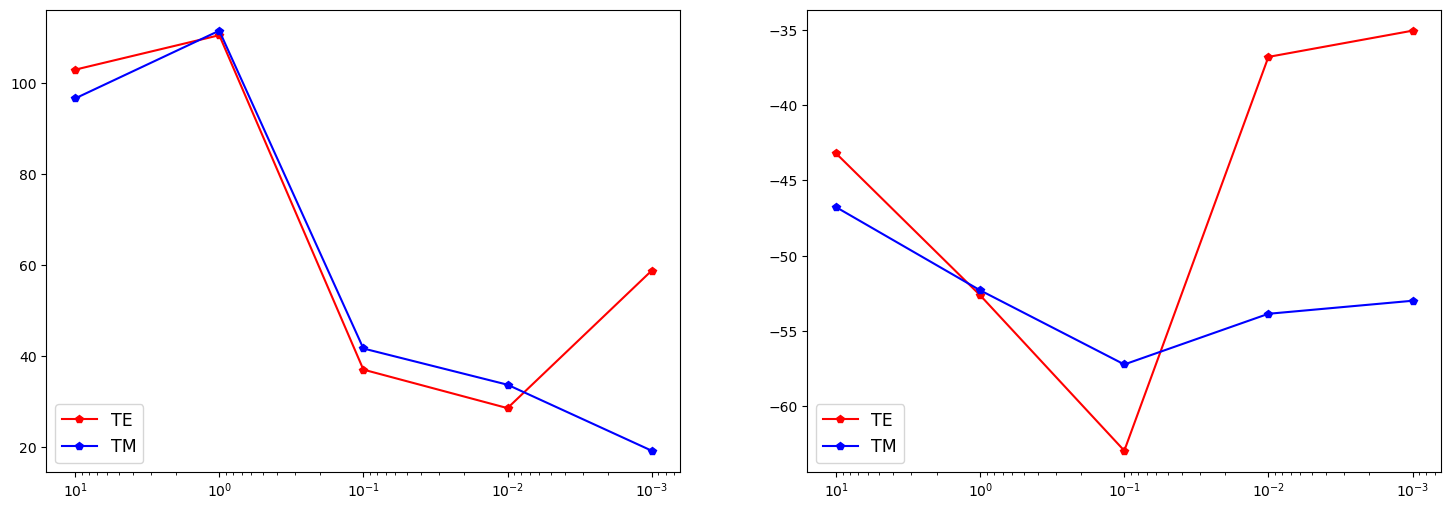

In [26]:
fig = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax.plot(freq, rhoxy[:,0], 'rp-',label="TE")
ax.plot(freq, rhoyx[:,0], 'bp-',label="TM")
ax.set_xscale("log")
ax.invert_xaxis()
ax.legend(loc='lower left',fontsize=12.5)
ax = plt.subplot(1,2,2)
ax.plot(freq, phsxy[:,0], 'rp-',label="TE")
ax.plot(freq, phsyx[:,0]-180, 'bp-',label="TM")
ax.set_xscale("log")
ax.invert_xaxis()
ax.legend(loc='lower left',fontsize=12.5)
plt.show()

## Abnormal Body Model

In [28]:
def generate_model(nza, y, z, size_b, size_k, n_freq, alpha = 3.0, mode='random', set_1=100.0, set_2=100.0):
    '''
    nza   : number of air layer
    y     : [-y,y]
    z     : [0,z]: 
    size_b: number of nodes from boundary to kernel domain
    size_k: kernel domain,
    n_freq: number of frequency
    alpha : smoothness of gaussian random field,the larger the more smooth;
    mode  : if random, 下面是mean和std，if bounda, 是lower和upper
    '''
    z_air = np.linspace(-z,0,nza+1)
    zn0 = np.linspace(0, z, size_k+1)
    z_b = np.linspace(zn0[-1],2*zn0[-1],size_b+1)
    zn  = np.concatenate((z_air[:-1],zn0,z_b[1:]))
    # zn  = zn.reshape((len(zn),1))

    yn0 = np.linspace(-y,y,size_k+1)
    y_l = np.linspace(2*yn0[0],yn0[0],size_b+1)
    y_r = np.linspace(yn0[-1],2*yn0[-1],size_b+1)
    yn  = np.concatenate((y_l[:-1],yn0,y_r[1:]))
    # yn  = yn.reshape((len(yn),1)) - np.min(yn)
#     y0 = yn-y_l[0]
    
    freq = np.logspace(1,-3,n_freq)
    # freq = freq.reshape((len(freq),1))
    ry = np.linspace(-y,y,size_k+1)
    # ry = ry.reshape((len(ry),1))-np.min(ry)

    sig = np.ones((size_b+size_k+nza,2*size_b+size_k))*1e-2
    sig[:nza,:] = 1e-9
    sig[nza+5:nza+10,size_b+2:size_b+6]= 1e-1
    sig[nza+5:nza+10,size_b+10:size_b+14]= 1e-3
#     model0 = gr.gaussian_random_field(alpha = alpha, size = size_k, 
#                                    mode=mode, set_1=set_1, set_2=set_2)
#     model[int(size_b/2)+1:int(size_b/2)+size_k+1, :size_k] = model0
    return zn, yn, freq, ry, sig

In [29]:
ry

array([-10000.,  -9000.,  -8000.,  -7000.,  -6000.,  -5000.,  -4000.,
        -3000.,  -2000.,  -1000.,      0.,   1000.,   2000.,   3000.,
         4000.,   5000.,   6000.,   7000.,   8000.,   9000.,  10000.])

In [30]:
zn, yn, freq, ry, sig = generate_model(nza, y, z, size_b, size_k, n_freq, alpha, mode, set_1, set_2)
model = MT2DFD(nza, zn, yn, freq, ry, sig)

rhoxy, phsxy,Zxy,rhoyx,phsyx,Zyx  = model.mt2d("TETM")

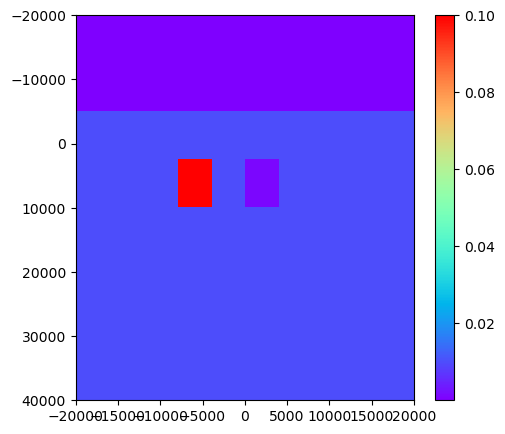

In [31]:


fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)
h = ax.imshow(sig, interpolation='nearest', cmap='rainbow', 
              extent=[yn.min(), yn.max(), zn.min(), zn.max()], 
              origin='lower', aspect='auto')
ax.invert_yaxis()
fig.colorbar(h)
plt.show()



frequency is:0.001



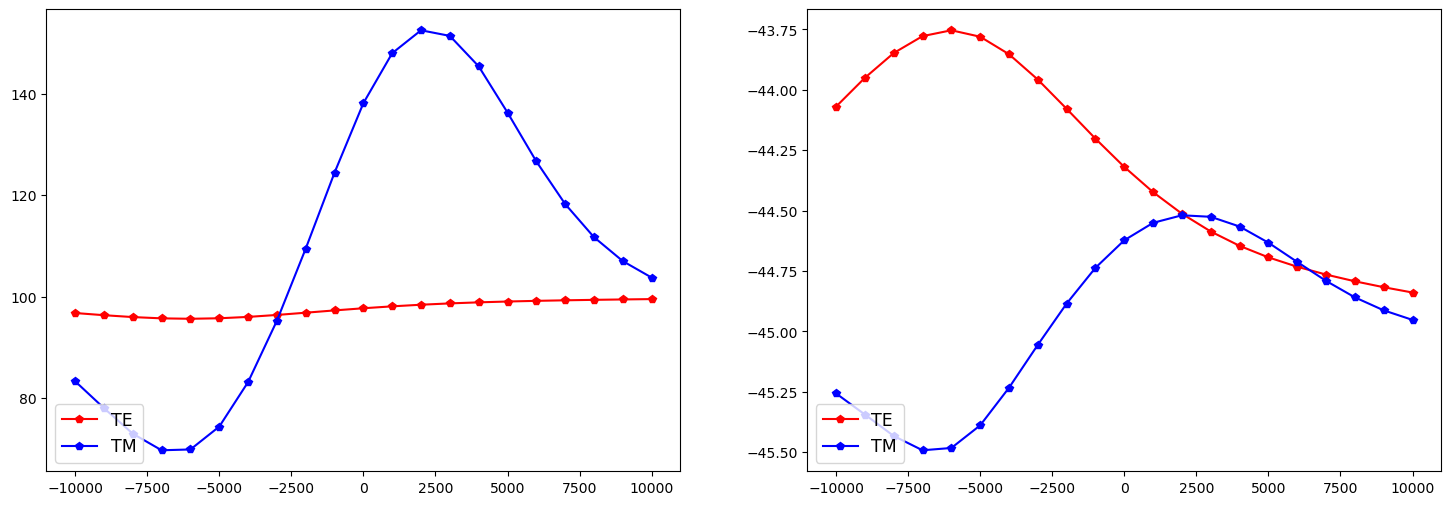

In [32]:


f_id = -1 # idx of frequency
print(f"frequency is:{freq[f_id]}")
print("")
fig = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax.plot(ry, rhoxy[f_id,:], 'rp-',label="TE")
ax.plot(ry, rhoyx[f_id,:], 'bp-',label="TM")
# ax.set_xscale("log")
# ax.invert_xaxis()
ax.legend(loc='lower left',fontsize=12.5)
ax = plt.subplot(1,2,2)
ax.plot(ry, phsxy[f_id,:], 'rp-',label="TE")
ax.plot(ry, phsyx[f_id,:]-180, 'bp-',label="TM")
# ax.set_xscale("log")
# ax.invert_xaxis()
ax.legend(loc='lower left',fontsize=12.5)
plt.show()



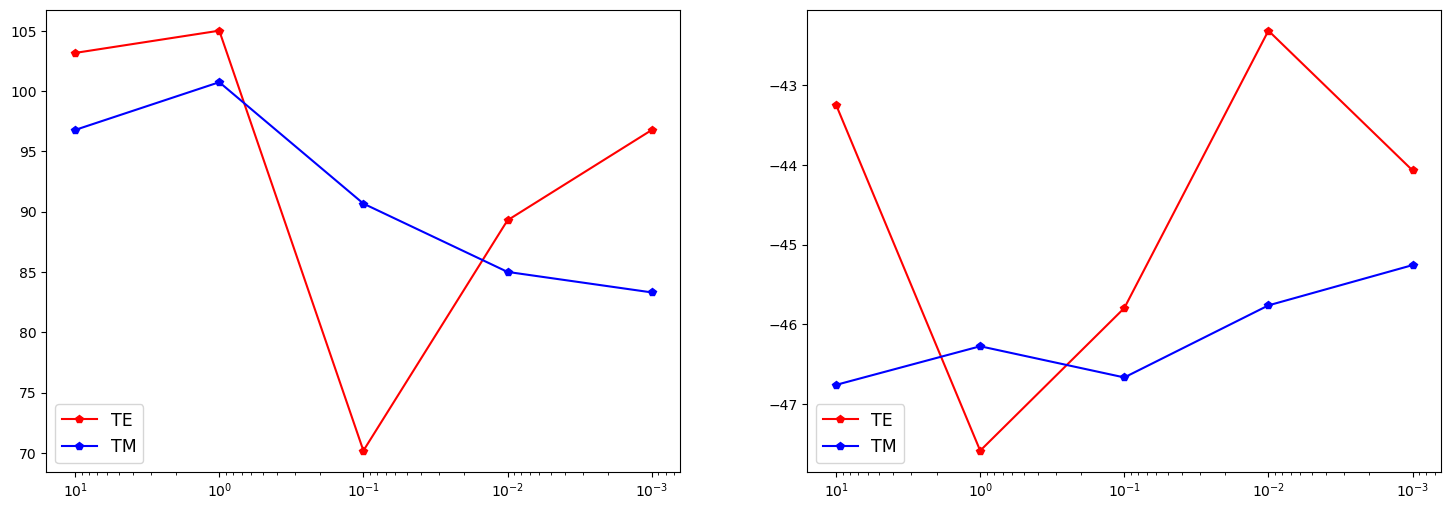

In [33]:


fig = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax.plot(freq, rhoxy[:,0], 'rp-',label="TE")
ax.plot(freq, rhoyx[:,0], 'bp-',label="TM")
ax.set_xscale("log")
ax.invert_xaxis()
ax.legend(loc='lower left',fontsize=12.5)
ax = plt.subplot(1,2,2)
ax.plot(freq, phsxy[:,0], 'rp-',label="TE")
ax.plot(freq, phsyx[:,0]-180, 'bp-',label="TM")
ax.set_xscale("log")
ax.invert_xaxis()
ax.legend(loc='lower left',fontsize=12.5)
plt.show()



## Complex Model Testing

## Tested with the COMMITID 2D-0 model



In [38]:
from time import time
import matplotlib.colors as colors



In [39]:
# COMMEMI 2D-0 model reference apparent resistancy
obs_TE = np.array([-25,-15,-7,7,10,15,30])
rho_TE = np.array([8.0,4.7,1.5,1.1,1.3,1.7,2.0])
obs_TM = np.array([-25,-15,-10,0,10,15,30])
rho_TM = np.array([11.21,12.64,16.12,0.98,0.67,2.11,2.01])

In [40]:
def generate_model(nza):
    y = 10e3    # lenght in left and right 
    z = 50e3    # depth
#     n_freq = 5  
    nz = 50
    nz_b =10
    ny = 30
    
    z_air = np.linspace(-200e3,0,nza+1)
    zn0 = np.linspace(0, z, nz+1)
    z_b = np.linspace(zn0[-1],10*zn0[-1],nz_b+1)
    zn  = np.concatenate((z_air[:-1],zn0,z_b[1:]))
    # zn  = zn.reshape((len(zn),1))

    yn0 = np.linspace(-y,y,ny+1)
    y_l = np.linspace(5*yn0[0],yn0[0],ny+1)
    y_r = np.linspace(yn0[-1],5*yn0[-1],ny+1)
    yn  = np.concatenate((y_l[:-1],yn0,y_r[1:]))
    # yn  = yn.reshape((len(yn),1)) - np.min(yn)
#     y0 = yn-y_l[0]
    
    freq = np.array([1.0/300])
    # freq = freq.reshape((len(freq),1))
    ry = np.linspace(-30e3,30e3,100+1)
    # ry = ry.reshape((len(ry),1))-np.min(ry)

    sig = np.ones((nz+nz_b+nza,3*ny))*1e-2
    sig[:nza,:] = 1e-9
    sig[nza:nza+nz,0:ny] = 1.0/10
    sig[nza:nza+nz,ny:2*ny] = 1.0
    sig[nza:nza+nz,2*ny:] = 1.0/2
    
#     model0 = gr.gaussian_random_field(alpha = alpha, size = size_k, 
#                                    mode=mode, set_1=set_1, set_2=set_2)
#     model[int(size_b/2)+1:int(size_b/2)+size_k+1, :size_k] = model0
    return zn, yn, freq, ry, sig

In [41]:
nza = 10
zn, yn, freq, ry, sig = generate_model(nza)

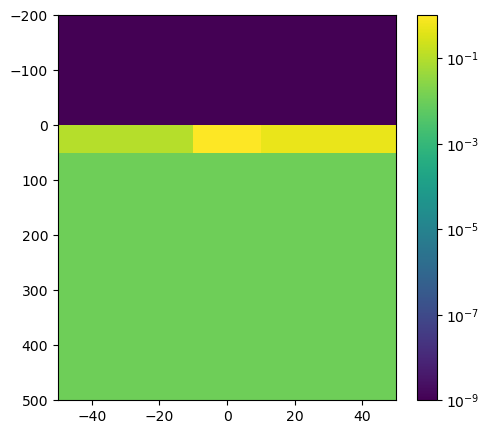

In [42]:


fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)
Y,Z = np.meshgrid(yn,zn)
h = ax.pcolormesh(Y/1e3,Z/1e3, sig, 
                  norm=colors.LogNorm(vmin=sig.min(), vmax=sig.max()),
                  )
ax.invert_yaxis()
fig.colorbar(h)
plt.show()




In [43]:


model = MT2DFD(nza, zn, yn, freq, ry, sig)

rhoxy, phsxy,Zxy,rhoyx,phsyx,Zyx  = model.mt2d("TETM")



frequency is: 300.0s



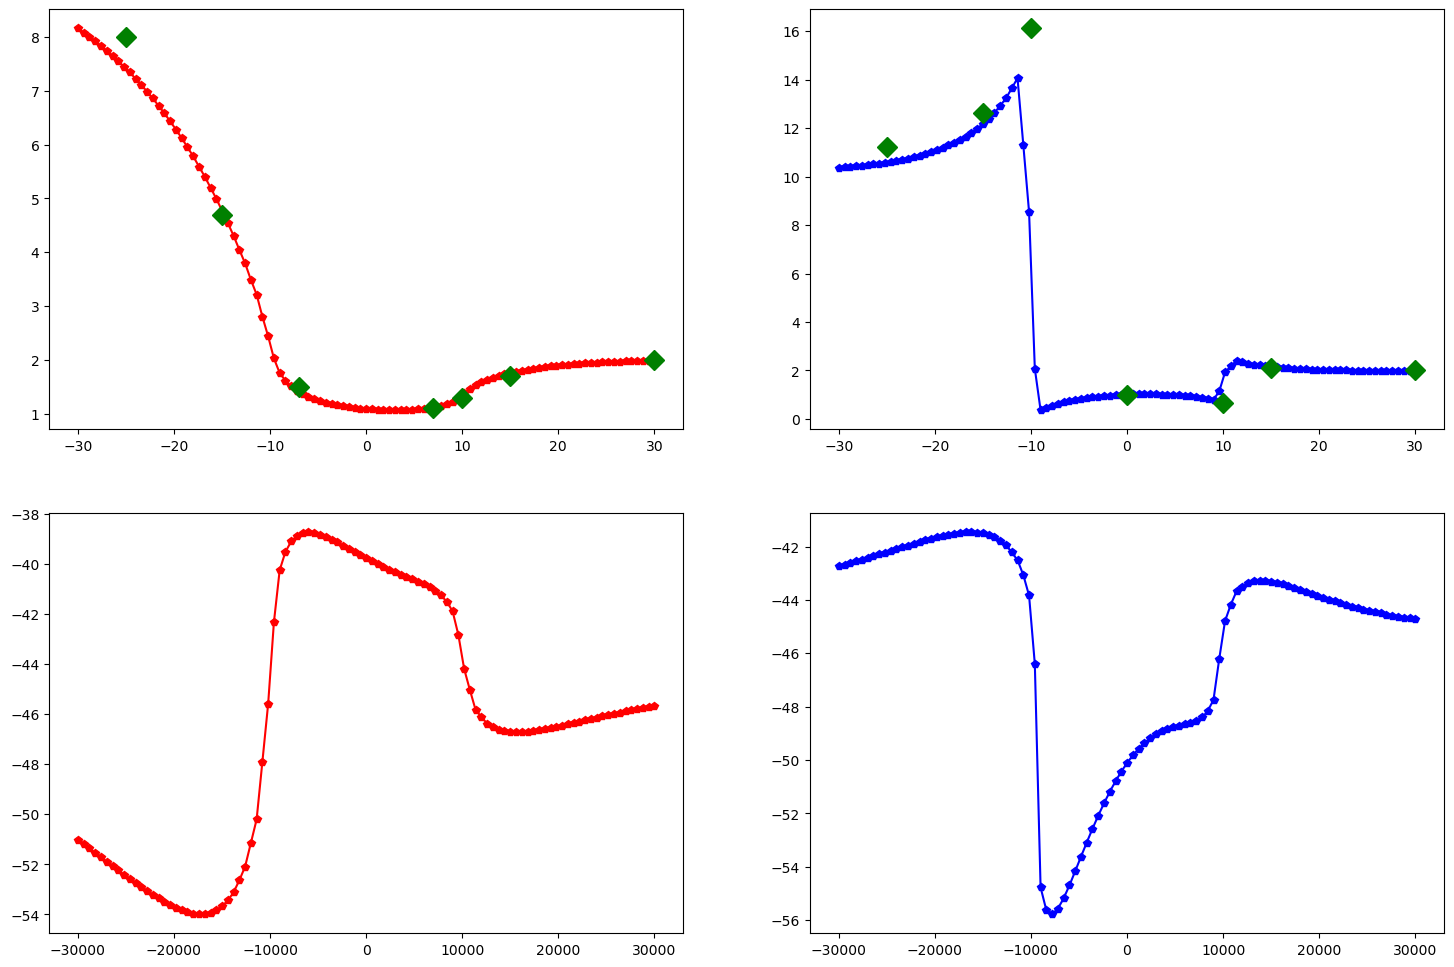

In [44]:


f_id = -1 # idx of frequency
print(f"frequency is: {1.0/freq[f_id]}s")
print("")
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(2,2,1)
ax.plot(ry/1e3, rhoxy[f_id,:], 'rp-',label="TE")
ax.plot(obs_TE, rho_TE, 'gD', markersize=10,label="COMMEMI")

ax = plt.subplot(2,2,2)
ax.plot(ry/1e3, rhoyx[f_id,:], 'bp-',label="TM")
ax.plot(obs_TM, rho_TM, 'gD', markersize=10,label="COMMEMI")
# ax.set_xscale("log")
# ax.invert_xaxis()
# ax.legend(loc='lower left',fontsize=12.5)
ax = plt.subplot(2,2,3)
ax.plot(ry, phsxy[f_id,:], 'rp-',label="TE")
ax = plt.subplot(2,2,4)
ax.plot(ry, phsyx[f_id,:]-180, 'bp-',label="TM")
# ax.set_xscale("log")
# ax.invert_xaxis()
# ax.legend(loc='lower left',fontsize=12.5)
plt.show()

